In [232]:
import os

import pytz
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import matplotlib

from sklearn import cluster
from random import randint

In [214]:
sns.color_palette("crest", as_cmap=True)
sns.set_palette("crest")

In [215]:
path_data = "../../data"

filename_entete = "entete.csv"

# équivalent à path_data + filename_meteo et s'assure que le path est de la bonne forme
path_data_entete = os.path.join(path_data, filename_entete)
# affiche le chemin path_data_meteo
print(path_data_entete)

../../data/entete.csv


In [216]:
df_entete = pd.read_csv(path_data_entete, sep=",")

df_entete = df_entete.loc[
    (df_entete["TypCde"] == "C") & (df_entete["CAHT"] > 0)
]

df_entete["DateCreation"] = df_entete["DateCreation"].astype('datetime64')

df_entete = df_entete[{"CodeClient", "DateCreation"}].sort_values(['CodeClient', 'DateCreation'])

df_entete

,DateCreation,CodeClient
12045,2018-11-12,1
40737,2020-07-30,1
39220,2020-09-10,1
51644,2021-02-12,1
56433,2021-05-03,1
...,...,...
72105,2022-03-10,14709
72832,2022-04-06,14727
72525,2022-04-07,14734
73029,2022-04-05,14738


In [217]:
df_entete.dtypes

DateCreation    datetime64[ns]
CodeClient               int64
dtype: object

In [218]:
df_duplicates = df_entete.drop_duplicates(subset=['CodeClient'], keep=False)

df_duplicates["DateCreation"] = pd.to_datetime('2022-04-19')

df_entete = df_entete.append(df_duplicates)

df_entete['DateCreation'].apply(lambda x: x.replace(tzinfo=None))

df_entete

/var/folders/36/43f3rdln6_jby4rr0llzz6yh0000gn/T/ipykernel_28479/3077096763.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_duplicates["DateCreation"] = pd.to_datetime('2022-04-19')


,DateCreation,CodeClient
12045,2018-11-12,1
40737,2020-07-30,1
39220,2020-09-10,1
51644,2021-02-12,1
56433,2021-05-03,1
...,...,...
72105,2022-04-19,14709
72832,2022-04-19,14727
72525,2022-04-19,14734
73029,2022-04-19,14738


In [219]:
df_frequence = df_entete.groupby("CodeClient").apply(lambda x: x["DateCreation"].diff().astype('timedelta64[D]', errors='ignore').mean(skipna=True)).reset_index()

df_frequence.columns = ["CodeClient", "Frequence"]

df_frequence

,CodeClient,Frequence
0,1,149.750000
1,3,100.857143
2,12,370.000000
3,13,708.000000
4,22,1310.000000
...,...,...
2793,14709,40.000000
2794,14727,13.000000
2795,14734,12.000000
2796,14738,14.000000


In [220]:
df_frequence_bins = df_frequence['Frequence'].value_counts(bins = [0, 30, 90, 180, 365, 999999999]).reset_index().rename(columns={'index': 'Frequences', 'Frequence': 'Nombre'}).sort_values(["Frequences"])

df_frequence_bins['Frequences'] = [(round(x.left), round(x.right)) for x in df_frequence_bins['Frequences']]

df_frequence_bins

,Frequences,Nombre
4,"(0, 30)",173
3,"(30, 90)",341
2,"(90, 180)",532
1,"(180, 365)",591
0,"(365, 999999999)",1161


In [221]:
df_ca = pd.read_csv(path_data_entete, sep=",")

df_ca = df_ca .loc[
    (df_ca["TypCde"] == "C") & (df_ca["CAHT"] > 0)
]

df_ca  = df_ca [{"CodeClient", "CAHT"}]

df_ca

,CAHT,CodeClient
0,2065.80,2625
1,16960.51,5505
4,1748.40,10497
8,17951.01,10721
10,2083.47,1826
...,...,...
73958,816.56,2334
73973,313.88,219
73976,565.75,10510
73977,650.48,9977


In [222]:
df_ca = df_ca.groupby("CodeClient")["CAHT"].mean().reset_index()

df_ca

,CodeClient,CAHT
0,1,556.491111
1,3,2126.936667
2,12,2889.900000
3,13,1135.780000
4,22,2253.280000
...,...,...
2793,14709,3829.410000
2794,14727,1384.460000
2795,14734,5458.580000
2796,14738,460.340000


In [223]:
df_ca_bins = df_ca['CAHT'].value_counts(bins = [0, 500, 1000, 5000, 20000, 999999999]).reset_index().rename(columns={'index': 'CAHTs', 'CAHT': 'Nombre'}).sort_values(["CAHTs"])

df_ca_bins['CAHTs'] = [(round(x.left), round(x.right)) for x in df_ca_bins['CAHTs']]

df_ca_bins

,CAHTs,Nombre
2,"(0, 500)",564
1,"(500, 1000)",1028
0,"(1000, 5000)",1097
3,"(5000, 20000)",96
4,"(20000, 999999999)",13


# GRAPHIQUES

<AxesSubplot:xlabel='Frequences'>

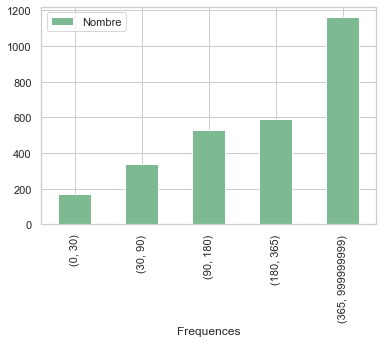

In [224]:
df_frequence_bins.plot(x="Frequences", y="Nombre", kind="bar")

<AxesSubplot:xlabel='CAHTs'>

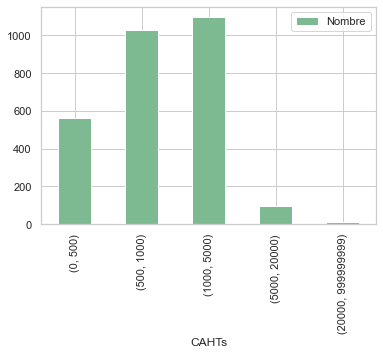

In [225]:
df_ca_bins.plot(x="CAHTs", y="Nombre", kind="bar")

In [226]:
df_matrix = pd.merge(df_frequence, df_ca, how="inner", on="CodeClient")

df_matrix

,CodeClient,Frequence,CAHT
0,1,149.750000,556.491111
1,3,100.857143,2126.936667
2,12,370.000000,2889.900000
3,13,708.000000,1135.780000
4,22,1310.000000,2253.280000
...,...,...,...
2793,14709,40.000000,3829.410000
2794,14727,13.000000,1384.460000
2795,14734,12.000000,5458.580000
2796,14738,14.000000,460.340000


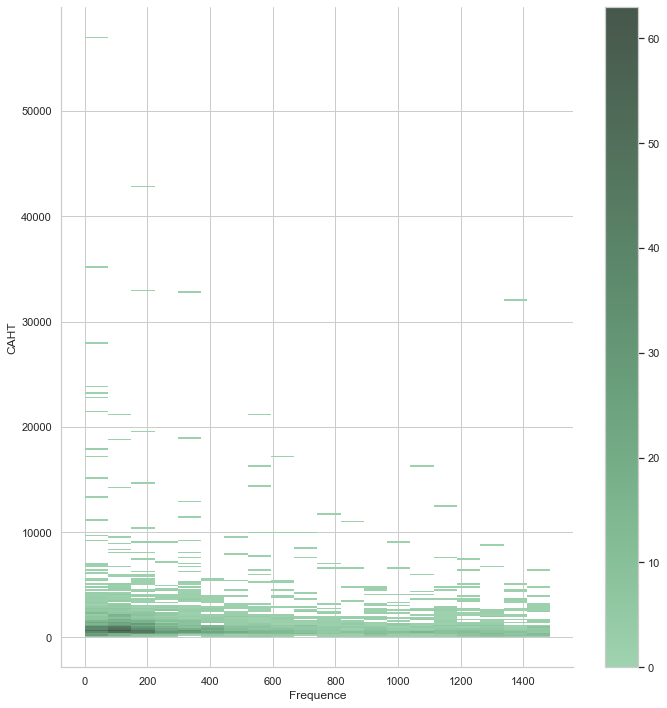

In [227]:
sns.displot(df_matrix, x="Frequence", y="CAHT", cbar=True, height=10, aspect=1/1)

In [228]:
df_matrix.loc[
    (df_matrix["CAHT"] > 10000) & (df_matrix["Frequence"] > 365)
]

,CodeClient,Frequence,CAHT
1313,4819,851.0,10973.48
1470,5561,557.0,16334.05
1787,10040,784.0,11702.57
1817,10167,524.0,14311.35
1994,10916,1139.0,12429.37
2289,12041,1372.0,32049.03
2379,12294,559.0,21172.64
2406,12397,662.0,10021.93
2449,12542,1104.0,16285.28
2584,13088,657.0,17215.35


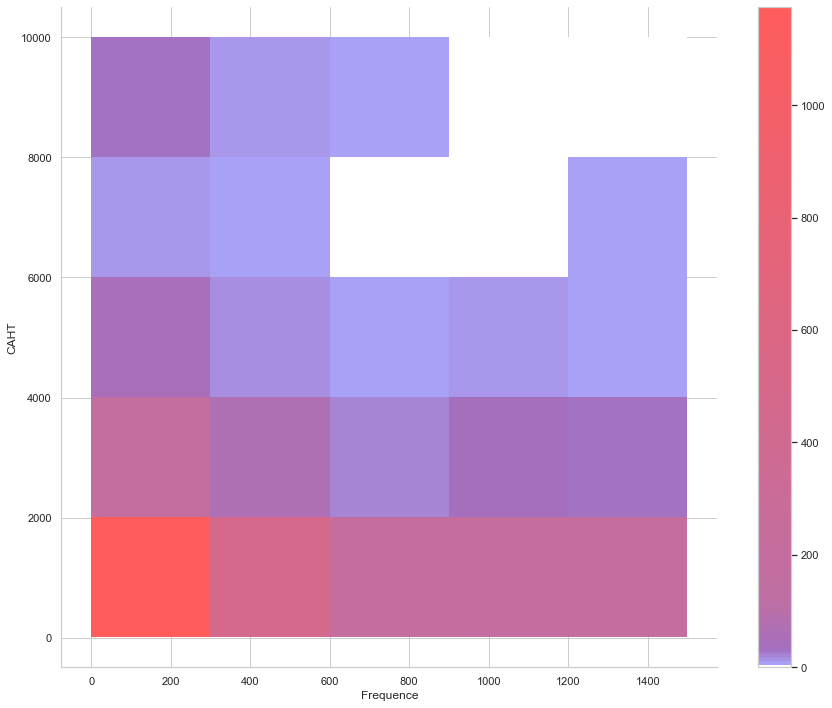

In [258]:
df_matrix_clip = df_matrix
df_matrix_clip["CAHT"] = df_matrix_clip["CAHT"].clip(upper=10000)

norm = matplotlib.colors.Normalize(-1,1)
colors = [[0, "#FFFFFF"],
          [norm(-1), "#AAAAFF"],
          [norm(-0.95), "#a46fbf"],
          [norm(-0.8), "#bf6fa4"],
          [norm(1), "#ff5c5c"]]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

sns.displot(df_matrix_clip, x="Frequence", y="CAHT", cbar=True, height=10, aspect=5/4, binwidth=(300, 2000), cmap=cmap)

In [259]:
df_matrix = df_matrix[{"Frequence", "CAHT"}]

df_matrix

,Frequence,CAHT
0,149.750000,556.491111
1,100.857143,2126.936667
2,370.000000,2889.900000
3,708.000000,1135.780000
4,1310.000000,2253.280000
...,...,...
2793,40.000000,3829.410000
2794,13.000000,1384.460000
2795,12.000000,5458.580000
2796,14.000000,460.340000
